In [1]:
## call the main routines
using NBInclude
@nbinclude("core_fun.ipynb");

We fix the parameters for the case of France in an object of type Country. The calibrated values for $\alpha$, $m$ and $q$ (and $\lambda$) are obtained latter on.

In [2]:
lambda_function(q) = 1/quadgk(x-> UIpolicy_france(x) * q * exp(-q*x), 0, Inf)[1] 

france = let 
    
    reform = 1
    A = 25.  *12 # entitlement age to RMI
    Amin = 20. *12
    Amax = 36. *12
    
    r = 0.0048 # 5 % annual interest rate, time unit = month
    c0 = 1. # scale parameter of the cost function, normalized to 1 
    
    ### to be updated after the calibration
    alpha, m, q =  0.3, 0.3, 0.07
    lambdamin = lambda_function(q)
    lambdamax = lambda_function(q)
  
    uinit = [0.36,0.] ## start with 64% employment rate, 36% without UI
    
    b0max = 539 # RMI+housing benefits, from BD2011
    b0min = 206 # housing benefits without RMI, from BD2011
    wbar = 1.66 * b0max # average wage, 66% increase in relative gains from working for HS dropouts, from BD2011    
    b0max /= wbar
    b0min /= wbar
    wbar = 1
    bUI = 0.68   # 68% replacement rate from DARES
    
    Country(reform,A,Amin,Amax,r,c0,alpha,q,m,lambdamin,lambdamax,uinit,bUI,b0max,b0min,wbar)
end
;

# 1) Find $\alpha$, $m$ and $q$
We take as moments the employment rates from 24 to 26.

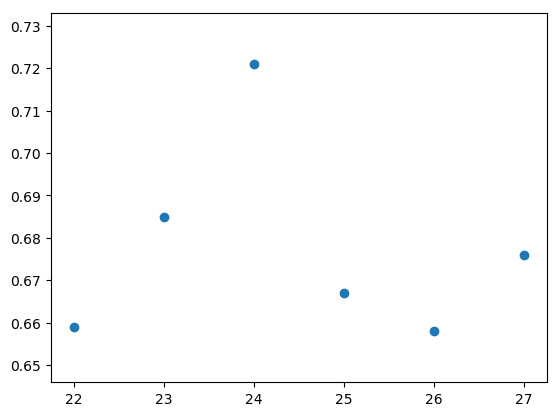

distance (generic function with 1 method)

In [3]:
function moments_france(unemp,simu::Simu,C::Country)
   # Y22 = quadgk(x->1-sum(unemp(x)[:]) ,22*12,22*12+12)[1]/12
   # Y23 = quadgk(x->1-sum(unemp(x)[:]) ,23*12,23*12+12)[1]/12
    Y24 = quadgk(x->1-sum(unemp(x)[:]) ,24*12,24*12+12)[1]/12
    Y25 = quadgk(x->1-sum(unemp(x)[:]) ,25*12,25*12+12)[1]/12
    Y26 = quadgk(x->1-sum(unemp(x)[:]) ,26*12,26*12+12)[1]/12
   # Y27 = quadgk(x->1-sum(unemp(x)[:]) ,27*12,27*12+12)[1]/12
    return(    [ Y24, Y25, Y26])
end

moments_target = let
    Y22, Y23, Y24, Y25, Y26, Y27 = 0.659, 0.685, 0.721, 0.667, 0.658, 0.676
    scatter(22:27, [Y22, Y23, Y24, Y25, Y26, Y27])
    [Y24, Y25, Y26]
end

function distance(m1,m2)
    out = 0
    for i in 1:length(m1)
        out += (m1[i] - m2[i]) ^2  
    end
    return(out)
end

We calibrate our model to determine the values of $\alpha$, $m$ and $q$ (and $\lambda$).

In [4]:
## generate a Country object with new values for alpha, m, q and lambda
function update_Country(alpha,m,q,C::Country)
    Country(C.reform,C.A,C.Amin,C.Amax,C.r,C.c0,
        alpha, q, m,lambda_function(q),lambda_function(q),
        C.uinit,C.bUI,C.b0max,C.b0min,C.wbar)
end

## compute the objective to minimise
function objective_fr(alpha,m,q,C::Country)
    newC = update_Country(alpha,m,q,C)
    
    ## simulate
    simu = find_simu(newC,reltol=1e-6)
    unemp = find_unemp(simu, newC, unitSS = false) 
    moments_emp = moments_france(unemp,simu,newC)
    
    IJulia.clear_output(true)
    println(alpha," ",m," ",q)
    println(moments_emp)
    
    distance(moments_emp,moments_target)
end

## distance minimisation with NLopt
@time parmin = let
    opt = Opt(:LN_BOBYQA, 3)
    lower_bounds!(opt, [0.1 , 0., 0.005])
    upper_bounds!(opt, [10. , 1., 0.2 ])
    xtol_rel!(opt,1e-8)
    stopval!(opt,1e-15)
    min_objective!(opt, (v,g)-> objective_fr(v[1],v[2],v[3],france))
    
    init =  [0.6, 0.7, 0.01] 
    
    (minf,minx,ret) = optimize(opt, init) 
    println("Param found with convergence ", ret, ", the value of the objective is ",minf)
    println("alpha, m, q= ", minx[1], " , ",minx[2], "  , ",minx[3])
    minx
end

france = update_Country(parmin[1],parmin[2],parmin[3], france)

0.3202815600931208 0.3153544032247785 0.07379265488958435
[0.720853, 0.667748, 0.657411]
Param found with convergence SUCCESS, the value of the objective is 9.27749939260869e-7
alpha, m, q= 0.3202815632160435 , 0.3153544036094311  , 0.07379265486964205
 47.968634 seconds (124.36 M allocations: 5.636 GiB, 9.15% gc time)


Country(1, 300.0, 240.0, 432.0, 0.0048, 1.0, 0.3202815632160435, 0.07379265486964205, 0.3153544036094311, 0.06813817970389542, 0.06813817970389542, [0.36, 0.0], 0.68, 0.6024096385542168, 0.23023448152535933, 1.0, 0.0008750568245853941, 0.011438576355427428)

# 2) Simulation

In [5]:
simu_fr = find_simu(france)
unemp_fr = find_unemp(simu_fr, france, unitSS = false) 
println("We print the targetted and simulated moments:")
hcat(moments_target,moments_france(unemp_fr,simu_fr,france))

We print the targetted and simulated moments:


3×2 Array{Float64,2}:
 0.721  0.720819
 0.667  0.667792
 0.658  0.657412

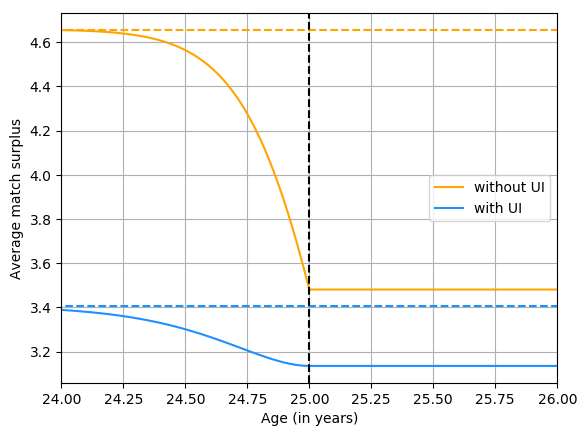

--- GRAPH DESCRIPTION ---
The blue continuous curve represents the match surplus when a worker receives UI benefits.
The orange continuous curve represents the match surplus when a worker only receives the social assistance.
The dashed curves are the curves for myopic agents.
-----


In [6]:
simuplot_surplus(simu_fr,france,xaxis=[24.,26.]*12)

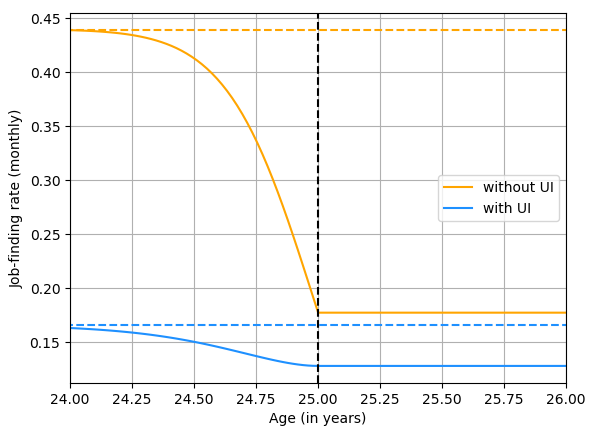

--- GRAPH DESCRIPTION ---
The blue continuous curve represents the job-finding rate when a worker receives UI benefits.
The orange continuous curve represents the job-finding rate when a worker only receives the social assistance.
The dashed curves are the curves for myopic agents.
-----


In [7]:
simuplot_JF(simu_fr,france,xaxis=[24.,26.]*12)

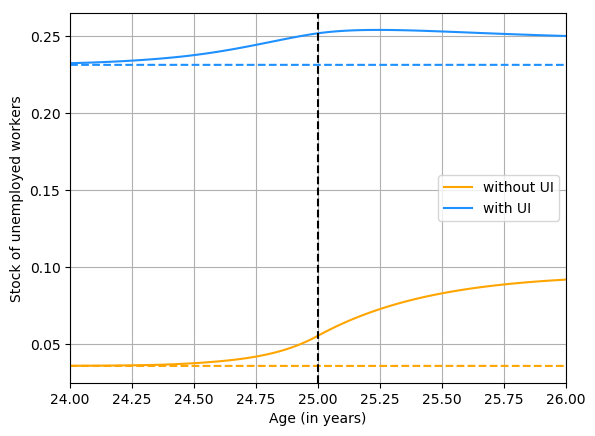

--- GRAPH DESCRIPTION ---
The blue continuous curve represents the unemployement rate with UI benefits.
The orange continuous curve represents the unemployment rate under the social assistance.
The dashed curves give the counterfactual dynamics without a policy change.
-----


In [8]:
unemp_fr_counter0 = find_unemp_counter0(simu_fr, france, unitSS = false) 
unemp_fr_counter1 = find_unemp_counter1(simu_fr, france, unitSS = false) 
simuplot_unemp(unemp_fr,unemp_fr_counter0, france, xaxis =[24,26]*12)

# 3) RDD with simulated model

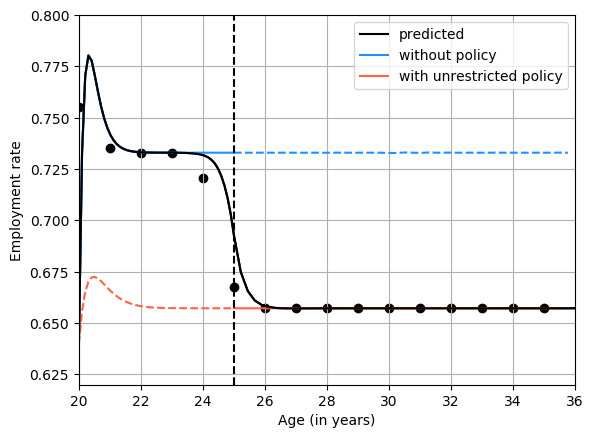

In [9]:
age_grid = 20:35
Y = [quadgk(x->1-sum(unemp_fr(x)[:]) ,m,m+12)[1]/12 for m in 12*age_grid] 
simuplot_emp_withpoints(unemp_fr, unemp_fr_counter0, unemp_fr_counter1, age_grid, Y,france, yaxis = [0.62,0.8])

RDD with yearly frequency

In [10]:
table_polynomial = zeros(5,2) #analoguous to the first part of table 1, "polynomial specification for age"
table_window = zeros(4,2) # analoguous to the second part of table 1, "Linear spline, with age window widths"

#explaining variables
TREAT = [a>=france.A for a in age_grid*12]
consta = ones(size(age_grid))
age1 = collect(age_grid*12)
age2 = age1 .^2
age3 = age1 .^3
age1_spl = (age1 .- france.A) .* TREAT 
age2_spl = (age1 .- france.A).^2 .* TREAT 

# linear
X = hcat(TREAT, consta, age1)
beta = inv(X' * X) * (X' * Y)
table_polynomial[1,1] = beta[1]

# quadratic
X = hcat(TREAT, consta, age1, age2)
beta = inv(X' * X) * (X' * Y)
table_polynomial[2,1] = beta[1]

# cubic
X = hcat(TREAT, consta, age1, age2, age3)
beta = inv(X' * X) * (X' * Y)
table_polynomial[3,1] = beta[1]

# linear spline, with different age window
X = hcat(TREAT, consta, age1, age1_spl)
beta = inv(X' * X) * (X' * Y)
table_polynomial[4,1] = beta[1]

# change window
for i=1:4
    window =[ (19+i)*12 <= a <= (31-i)*12 for a in age_grid*12]
    Ywin = Y[window]
    Xwin = X[window,:]
    beta = inv(Xwin' * Xwin) * (Xwin' * Ywin)
    table_window[i,1] = beta[1]
end
  
# quadratic spline
X = hcat(TREAT, consta, age1, age2, age1_spl, age2_spl)
beta = inv(X' * X) * (X' * Y)
table_polynomial[5,1] = beta[1] 


-0.05938687608701798

RDD with quarterly frequency

In [11]:
age_grid = 20:0.25:35
Y = [quadgk(x->1-sum(unemp_fr(x)[:]) ,m,m+3)[1]/3 for m in 12*age_grid] 

#explaining variables
TREAT = [a>=france.A for a in age_grid*12]
consta = ones(size(age_grid))
age1 = collect(age_grid*12)
age2 = age1 .^2
age3 = age1 .^3
age1_spl = (age1 .- france.A) .* TREAT 
age2_spl = (age1 .- france.A).^2 .* TREAT 

# linear
X = hcat(TREAT, consta, age1)
beta = inv(X' * X) * (X' * Y)
table_polynomial[1,2] = beta[1]

# quadratic
X = hcat(TREAT, consta, age1, age2)
beta = inv(X' * X) * (X' * Y)
table_polynomial[2,2] = beta[1]

# cubic
X = hcat(TREAT, consta, age1, age2, age3)
beta = inv(X' * X) * (X' * Y)
table_polynomial[3,2] = beta[1]

# linear spline, with different age window
X = hcat(TREAT, consta, age1, age1_spl)
beta = inv(X' * X) * (X' * Y)
table_polynomial[4,2] = beta[1]

# change window
for i=1:4
    window =[ (19+i)*12 <= a <= (31-i)*12 for a in age_grid*12]
    Ywin = Y[window]
    Xwin = X[window,:]
    beta = inv(Xwin' * Xwin) * (Xwin' * Ywin)
    table_window[i,2] = beta[1]
end
  
# quadratic spline
X = hcat(TREAT, consta, age1, age2, age1_spl, age2_spl)
beta = inv(X' * X) * (X' * Y)
table_polynomial[5,2] = beta[1]

println("Simulated")
display(table_polynomial)
display(table_window)

5×2 Array{Float64,2}:
 -0.0689045  -0.0675713
 -0.0526889  -0.0523102
 -0.0545278  -0.0541132
 -0.0534042  -0.0555967
 -0.0593869  -0.0524414

4×2 Array{Float64,2}:
 -0.0512143  -0.0522865
 -0.055806   -0.0543631
 -0.0519418  -0.0498311
 -0.0428313  -0.0402172

Simulated


In [12]:
table_polynomial_BaDo = -hcat([-0.027,-0.067,0.065,0.049,0.067],[-0.028,0.069,0.067,0.058,0.068])
table_window_BaDo = -hcat([0.052,0.06,0.065,0.067],[0.058,0.069,0.072,0.079])
println("Empirical")
display(table_polynomial_BaDo)
display(table_window_BaDo)

5×2 Array{Float64,2}:
  0.027   0.028
  0.067  -0.069
 -0.065  -0.067
 -0.049  -0.058
 -0.067  -0.068

4×2 Array{Float64,2}:
 -0.052  -0.058
 -0.06   -0.069
 -0.065  -0.072
 -0.067  -0.079

Empirical


In [13]:
## simulated effect of the polic
emp_after = 1-sum(unemp_fr_counter1(france.A)[:])
emp_before = 1-sum(unemp_fr_counter0(france.A)[:])
println("The simulated model gives a LATE at ")
emp_after-emp_before

The simulated model gives a LATE at 


-0.0757703364549197